
Calculate the density auto-correlation function multipoles $\xi_{dd,l}^s$
in redshift space, using package DDsmu


In [25]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path = '/Users/ngoc/Desktop/Master-study/project'

In [26]:

#cosmological parameters
z        = 0.306                                #redshift
H_0      = 67                                   #Hubble const
Omg_lamb = 0.685                                #cosmological density parameter
Omg_m    = 1. - Omg_lamb                        #mater density parameter
a        = 1./(1. + z)                          #scale factor
E_a      = np.sqrt(Omg_m*(1.+z)**3. + Omg_lamb) #parameter of Hubble H = E*H_0
f        = 0.687255861
b        = 3.11                                 #bias for halo b = \delta_halo/\delta_matter


In [27]:
#simulation paramters
boxsize  = 2000                    #length of 1D of the box [Mpc/h]
nthreads = 4                       #number of Open MP threads to use 
autocorr = 1                       #auto correlation
nbins    = 50                      #number of bins
rmin     = 1.
rmax     = boxsize/3
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)     
mu_max   = 1                       #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10                      #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins
ndata    = 8                       #number of data
set_data = "112345678"             #for reading the data



In [28]:
A_0 = np.zeros((ndata,nbins))
r   = np.zeros((ndata,nbins))
A_2 = np.zeros((ndata,nbins))
A_4 = np.zeros((ndata,nbins))


#Legendre polynomials
P0 = 1
P2 = lambda mu: (3*mu**2-1)/2
P4 = lambda mu: (35*mu**4 - 30*mu**2 + 3)/8 



In [29]:
for i in range (0,ndata):
#load positions of objects
    X = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat',
                   usecols = (1))
    Y = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat',
                   usecols = (2))
    Z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat',
                   usecols = (3))

    #load LOS velocities of objects (Z-direction is the LOS) 
    V_z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat',
                     usecols = (6))
    
    s   = Z + V_z/(a*E_a*100) 
    
    # PBC 
    for j in range(len(s)):
        if s[j] < 0:
            s[j] = s[j] + boxsize
        elif s[j] > boxsize:
            s[j] = s[j] - boxsize
        
    weights = np.full_like(X,1)
    
    #calculate random-random pairs 
    N_halo = len(X)
    RR     = (4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3))*N_halo*(N_halo-1)/boxsize**3
    
    #using DDsmu to calculate pair
    results_DDsmu = DDsmu(autocorr,
                          nthreads,
                          bins,
                          mu_max,
                          nmu_bins,
                          X, Y, s,
                          weights1    = weights,
                          boxsize     = boxsize,
                          weight_type = 'pair_product',
                          periodic    = True,
                          output_savg = True)
 
    # using mu value from F-corrfunc
    mu = np.loadtxt(path+'/my-f-code/results/xi-ddsmu-realization'+set_data[i+1]+'.txt', usecols = (2))
#    mu       = results_DDsmu['mu_max']
    r_mu     = results_DDsmu['savg']
    DD_r_mu  = results_DDsmu['npairs']*results_DDsmu['weightavg']
      
    #monopole
    DD_r= np.zeros(nbins)      
    xi0 = np.zeros(nbins)
    r0  = np.zeros(nbins)
    
    l   = 0 
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi0[ii] = xi0[ii] + (DD_r_mu[j]/(RR[ii]/nmu_bins)-1)*P0*delta_mu       
            r0[ii]  = r0[ii]  + r_mu[j]  
            DD_r[ii]= DD_r[ii]+ DD_r_mu[j]
            
    xi0 = (2*l+1)*xi0
    r0  = r0/nmu_bins
    
    A_0[i] = xi0
    r[i]   = r0
    
      
    #quadrupole
            
    xi2 = np.zeros(nbins)
    l   = 2
    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi2[ii] = xi2[ii] + (DD_r_mu[j]/(RR[ii]/nmu_bins)-1)*delta_mu*P2(mu[j])
   
    xi2    = (2*l+1)*xi2
    A_2[i] = xi2

  
    #hexadecapole
        
    xi4 = np.zeros(nbins)
    l   = 4    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi4[ii] = xi4[ii] + (DD_r_mu[j]/(RR[ii]/nmu_bins)-1)*delta_mu*P4(mu[j])
        
    xi4    = (2*l+1)*xi4 
    A_4[i] = xi4
    


RuntimeError: RuntimeError occurred

In [ ]:

#monopole
xi_dd0_s = np.zeros(nbins)
r_s      = np.zeros(nbins)

for i in range(0,nbins):
    r_s[i]      = np.mean(r[0:ndata,i])
    xi_dd0_s[i] = np.mean(A_0[0:ndata,i])


error_xi_dd0_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_0[j,i] - xi_dd0_s[i])**2.
    error_xi_dd0_s[i] = np.sqrt(a/(ndata-1)) #standard deviation
serror_xi_dd0_s = error_xi_dd0_s/np.sqrt(ndata)

#quadrupole
xi_dd2_s = np.zeros(nbins)
for i in range(0,nbins):
    xi_dd2_s[i] = np.mean(A_2[0:ndata,i])

error_xi_dd2_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_2[j,i] - xi_dd2_s[i])**2
    error_xi_dd2_s[i] = np.sqrt(a/(ndata-1))
serror_xi_dd2_s = error_xi_dd2_s/np.sqrt(ndata)


#hexadecapole
xi_dd4_s = np.zeros(nbins)
for i in range(0,nbins):
    xi_dd4_s[i] = np.mean(A_4[0:ndata,i])

error_xi_dd4_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_4[j,i] - xi_dd4_s[i])**2
    error_xi_dd4_s[i] = np.sqrt(a/(ndata))
serror_xi_dd4_s = error_xi_dd4_s/np.sqrt(ndata-1)




In [22]:
'''
theoretical calculations of the density-density correlation function multipoles
in redshift space, using package DDsmu
the cosmological parameters taken from the paper 1907.00750 
'''
beta = f/b
#relation between the real and redshift space power spectrum multipoles (Kaiser's coefficients)
K0   = 1 + 2/3*beta + 1/5*beta**2
K2   = 4/3*beta + 4/7*beta**2
K4   = 8/35*beta**2


In [30]:
# loading the power spectrum in realspace
k   = np.loadtxt(path+'/results/power_spectrum03.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum03.txt', usecols = (1))
#Pcut   = np.loadtxt(path+'/my-p-code/results/mPk_cut.txt', usecols = (1))
r  = np.loadtxt(path+'/my-p-code/xi_dd_redshiftspace_mono.txt', usecols=(0))
#r   = r_s # using the same distance as the simulation results to compare
P_k = spline(k, P)
#P_k_cut = spline(k,Pcut)

In [31]:
#monopole
h0         = HankelTransform(nu = 1/2, N = 3000, h = 1e-5)

f_0        = lambda k: P_k(k)*np.sqrt(k)/(np.pi*2)**(3/2)
xi_dd0_lin = 1/np.sqrt(r)*h0.transform(f_0,r, ret_err=False, inverse=True)*K0*b**2

#f_0_cut        = lambda k: P_k_cut(k)*np.sqrt(k)/(np.pi*2)**(3/2)
#xi_dd0_lin_cut = 1/np.sqrt(r)*h0.transform(f_0_cut,r, ret_err=False, inverse=True)*K0*b**2

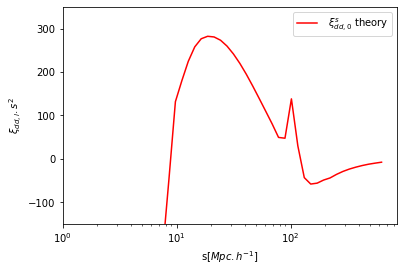

In [32]:
plt.semilogx(r, xi_dd0_lin*r**2, 'r-', label =" $\\xi^s_{dd,0}$ theory")
#plt.plot(r,    -xi_dd2_lin*r**2, 'b-', label ="-$\\xi^s_{dd,2}$ theory")
#plt.plot(r,     xi_dd4_lin*r**2, 'g-', label =" $\\xi^s_{dd,0}$ theory")
plt.xlim(1,)
plt.ylim(-150,350)
plt.xlabel('s$ [Mpc.h^{-1}]$')
plt.ylabel('$\\xi_{dd,l}. s^2$')
plt.legend()

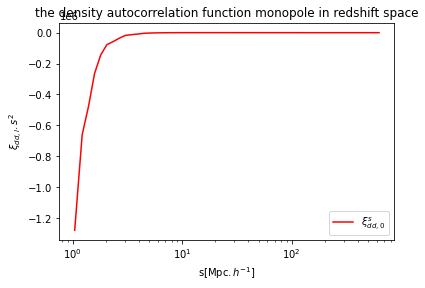

In [18]:
#plot the theory and simulation multipoles in the same plot
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
#for i in range(0,ndata):
#    ax.plot(r_s,A_0[i]*r_s**2,':')
#ax.errorbar(r, xi_dd0_s*r**2, fmt = 'r.' , yerr = error_xi_dd0_s*r**2, label='$\\xi^s_{dd,0}$ simulation')
#ax.errorbar(r_s,  xi_dd0_s*r_s**2, fmt = 'c-' , yerr = (1+xi_dd0_s)/np.sqrt(DD_r)*r_s**2, label=' $\\xi^s_{dd,0}$ Poisson err')
ax.plot(r, xi_dd0_lin*r**2, 'r-', label="$\\xi^s_{dd,0}$")
ax.set_ylabel("$\\xi_{dd,l}.s^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
ax.set_title('the density autocorrelation function monopole in redshift space')
ax.legend()
#ax.set_xlim(100,)
#ax.set_ylim(-100,200)
#plt.savefig('xi_dd0.png')

In [ ]:
#plot the theory and simulation multipoles in the same plot
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
#for i in range(0,ndata):
#    ax.plot(r_s, -A_2[i]*r_s**2,':')
ax.errorbar(r_s, -xi_dd2_s*r_s**2, fmt = 'b.', yerr = error_xi_dd2_s*r_s**2, label='-$\\xi^s_{dd,2}$ simulation')
ax.plot(r, -xi_dd2_lin*r**2, 'b--' , label="-$\\xi^s_{dd,2}$ theory")
ax.set_ylabel("$\\xi_{dd,l}.s^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
ax.set_title('The density autocorrelation function quadrupole in redshift space')
ax.legend()
#ax.set_xlim(100,)
#ax.set_ylim(-120,300)
#plt.savefig('xi_dd2.png')

In [ ]:
#plot the theory and simulation multipoles in the same plot
ax = plt.axes()
ax.set_xscale("log")
#for i in range(0,ndata):
#    ax.plot(r_s,A_4[i]*r_s**2,':')
ax.errorbar(r_s, xi_dd4_s*r_s**2, fmt = 'g.' , yerr = error_xi_dd4_s*r_s**2, label='$\\xi^s_{dd,4}$ simulation')
ax.plot(r, xi_dd4_lin*r**2, 'g-', label = "$\\xi^s_{dd,4}$theory")
ax.set_ylabel("$\\xi_{dd,l}.s^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
ax.set_title('The density autocorrelation function hexadecapole in redshift space')
ax.legend()
#ax.set_xlim(100,)
#ax.set_ylim(-150,300)
#plt.savefig('xi_dd4.png')